In [3]:
LOGIC = ["Negation", "Double negation", "Intervals/Numbers", "Conjunction", "Disjunction",
          "Conditionals", "Universal", "Existential", "Temporal", "Upward monotone",
          "Downward monotone", "Non-monotone",
        ]
LEXSEM = ["Lexical entailment", "Morphological negation", "Factivity", "Symmetry/Collectivity",
            "Redundancy", "Named entities", "Quantifiers",
         ]
PAS = ["Core args", "Prepositional phrases", "Ellipsis/Implicits", "Anaphora/Coreference",
        "Active/Passive", "Nominalization", "Genitives/Partitives", "Datives", "Relative clauses",
        "Coordination scope", "Intersectivity", "Restrictivity",
      ]
KNOWLEDGE = ["Common sense", "World knowledge"]

In [12]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction

ie_extractor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")

In [34]:
from Udep2Mono.dependency_parse import dependencyParse
from Udep2Mono.binarization import *
from Udep2Mono.util import *
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display
import os

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

parsed, replaced = dependencyParse("John ate an apple", "stanza")
tree, postag, words = parsed

# print("s")
# print(words)
# print(parseTreeCopy)
binarizer = Binarizer()

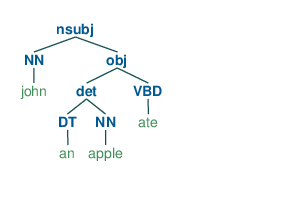

In [36]:
binarizer.parseTable = tree
binarizer.postag = postag
binarizer.words = words

sexpression = btreeToList(binaryDepdency, len(words), replaced, 0)[0]
sexpression = str(sexpression).replace(',', ' ').replace("'", '')
sexpression = sexpression.replace('[', '(').replace(']', ')')
btreeViz = Tree.fromstring(sexpression)
jupyter_draw_nltk_tree(btreeViz) 

In [6]:
from pattern.en import conjugate, lemma, lexeme, PAST, PRESENT, PARTICIPLE

def pass2act(sentence="John ate an apple"):
    ie_pred = ie_extractor.predict(sentence)['verbs']
    
    def fix_info(desc):
        out = desc.replace("ARG0: ", "")
        out = out.replace("ARG1: ", "")
        out = out.replace("V: ", "")
        out = out.replace("[", "")
        out = out.replace("]", ",")
        out = out.split(",")
        return out
    
    for verb in ie_pred:
        predicate = fix_info(verb['description'])
        print(predicate)
        passive = [0,0,0]
        passive[0] = predicate[2].strip()
        passive[2] = "by " + predicate[0].strip()
        passive_verb = conjugate(predicate[1].strip(), (PAST,PARTICIPLE), 1)
        passive[1] = "was " + passive_verb
        print(passive)

In [8]:
pass2act("John eat an apple")

['John', ' eat', ' an apple', '']
['an apple', 'was eaten', 'by John']


In [13]:
ie_extractor.predict(
  sentence="John took Lucy's book to study"
)

{'verbs': [{'verb': 'took',
   'description': "[ARG0: John] [V: took] [ARG1: Lucy 's book] [ARGM-PRP: to study]",
   'tags': ['B-ARG0',
    'B-V',
    'B-ARG1',
    'I-ARG1',
    'I-ARG1',
    'B-ARGM-PRP',
    'I-ARGM-PRP']},
  {'verb': 'study',
   'description': "[ARG0: John] took Lucy 's book to [V: study]",
   'tags': ['B-ARG0', 'O', 'O', 'O', 'O', 'O', 'B-V']}],
 'words': ['John', 'took', 'Lucy', "'s", 'book', 'to', 'study']}